## Resting-state functional connectivity in patients with fibromyalgia (FM) syndrome

Chia-Yu Cheng ● National Taiwan University ● Psychology

## Fibromyalgia (FM) syndrome
- chronic disorder that causes pain and tenderness throughout the body
- have pain in more than three locations in the body for more than three months (according to International Association for the Study of Pain)
- associated with sleep disturbances, fatigue, depression, anxiety, pain catastrophizing, and cognitive abilities (Lachaine et al., 2010; Glass, 2009)
- alterations in brain function (i.e. impaired inhibition of brain circuits)


Patients with fibromyalgia display less functional connectivity in the brain’s pain inhibitory network ( Jensen et al. 2012)
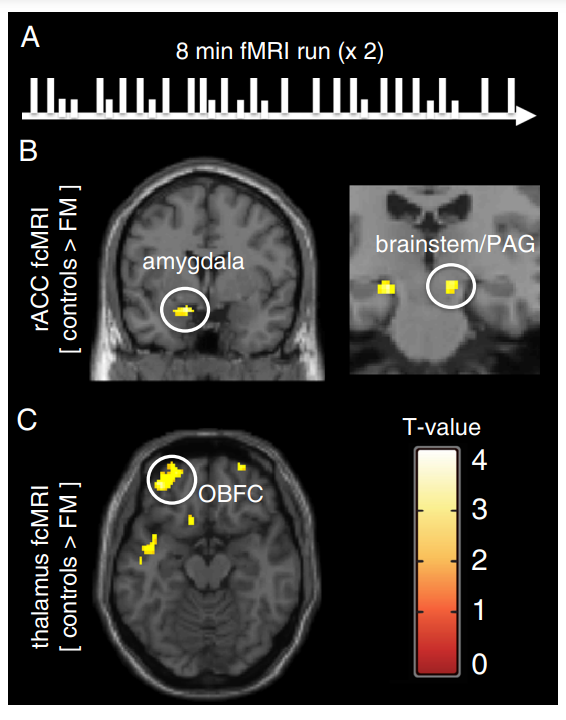

## The goal of this project
The functional connectivity between Fibromyalgia patients(FM) and Healthy control (HC) during resting state


# OpenNeuro
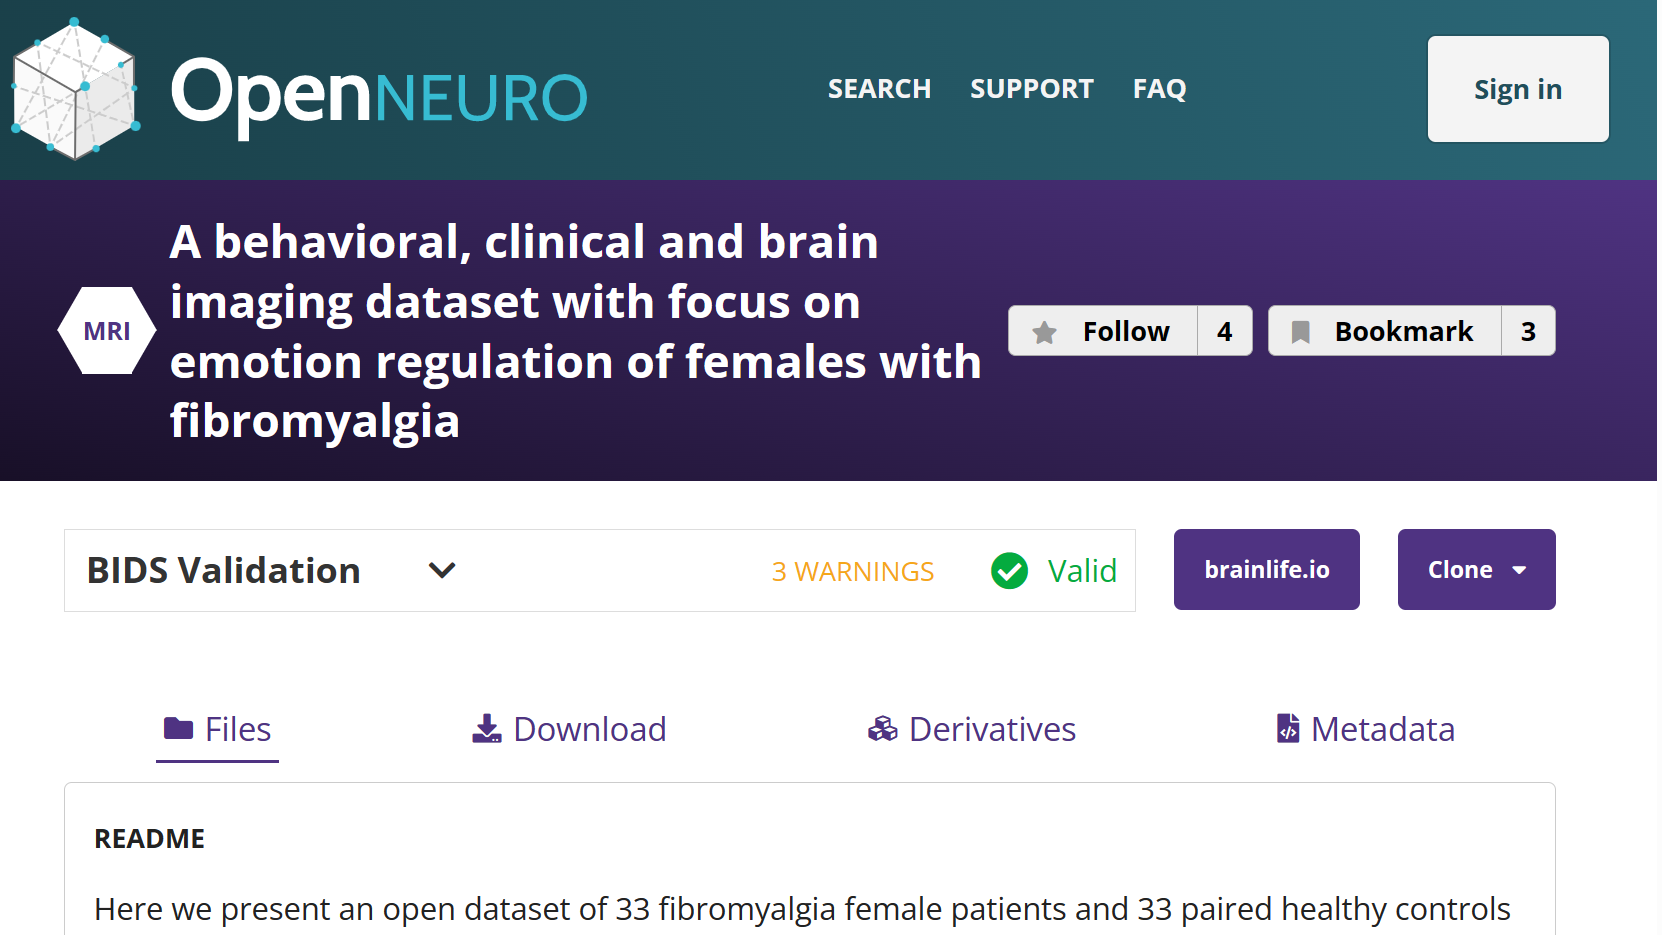

# Preprocessing
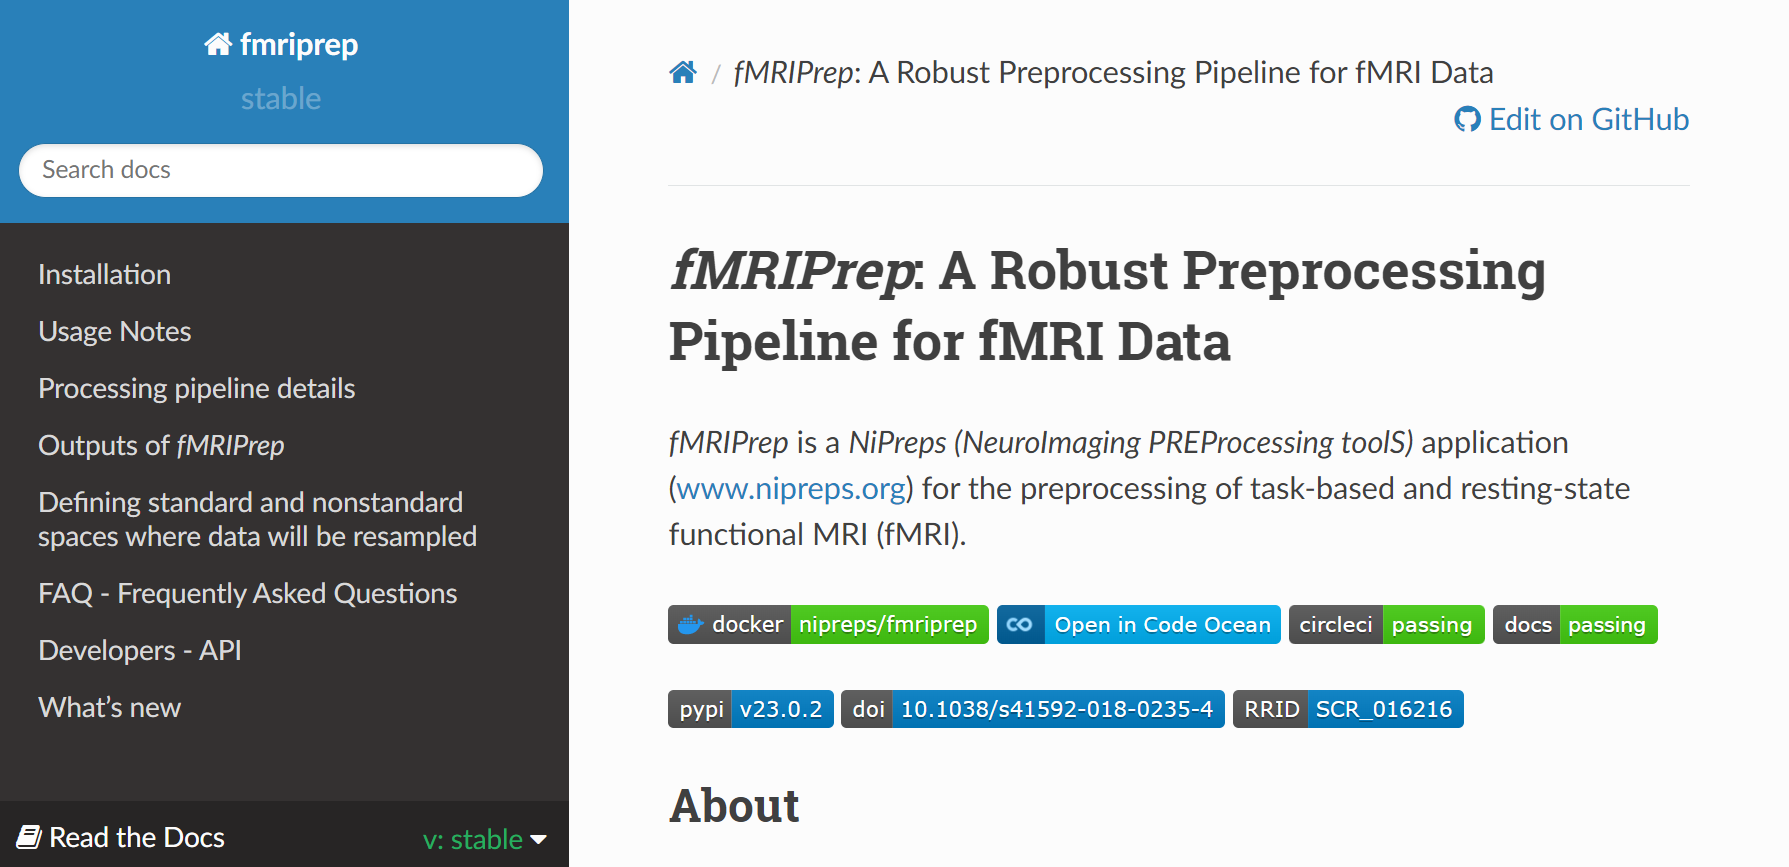

# Define ROIs using pain matrix (ROI to ROI fc)
For pain matrix, I focus on six regions: the thalamus, insular cortex (IC), primary and secondary somatosensory cortices (SI and SII), anterior cingulate cortex (ACC), and prefrontal cortex (PFC) (Morton et al., 2016).

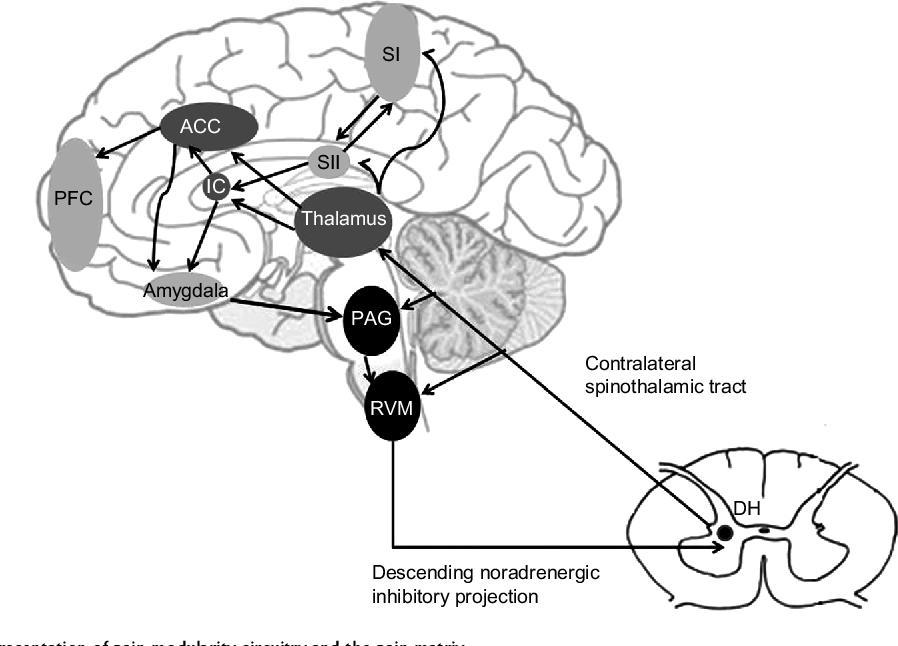

- The medial pathway (dark gray) projects from the medial thalamus to the ACC and IC and processes the affective-motivational component of pain (ie, unpleasantness). 
- The lateral pathway (light gray) projects from the lateral thalamus to the primary and secondary somatosensory cortices (SI and SII) and IC and processes the sensory-discriminative aspect of pain (ie, location and intensity). 
- Increased activation of the PFC is related to decreased pain affect purportedly by inhibiting the functional connectivity between the medial thalamus and the midbrain. 

In [1]:
pip install nilearn


Note: you may need to restart the kernel to use updated packages.


In [2]:
# %%
from nilearn import datasets
import numpy as np

# Download the AAL atlas
aal_atlas = datasets.fetch_atlas_aal(version='SPM12', verbose=1)
labels_filename = aal_atlas.labels

# %%
# The ROIs I'm interested will list here
roi_list = ["Thalamus", "Insula", "Cingulum_Ant", "Frontal_Inf_Tri", "Precentral", "Postcentral"]

# Use regular expression to find corresponding ROI name and its indices in aal_atlas.maps
import re
re_pattern = "|".join(roi_list)

roi_names = []
roi_indices = []
for i, roi_name in enumerate(aal_atlas.labels):
    if re.search(re_pattern, roi_name):
        roi_names.append(roi_name)
        roi_indices.append(aal_atlas.indices[i])

        print(f"No.{i+1:03d} ROI, {roi_name}, has value of {aal_atlas.indices[i]} in aal_atlas.maps")
# %%
# create my own all_atlas.maps, this maps only include the ROIs that I'm interested
from nilearn import image
roi_masks = [ image.math_img(f"(img == {idx}) * {i+1}", img = aal_atlas.maps) for i, idx in enumerate(roi_indices) ]
selected_aal_maps = image.math_img(f"np.sum(img, axis = 3)", img = image.concat_imgs(roi_masks))

# %%
# Use this new maps to extract ROI signal and generate report about my ROIs
from nilearn import maskers
aal_masker = maskers.NiftiLabelsMasker(
    labels_img=selected_aal_maps, labels=["background"] + roi_names, 
    detrend=True, standardize=True, smoothing_fwhm=6.0, high_pass=0.01, low_pass=0.1, t_r=2.0)
aal_masker.fit()
aal_masker.generate_report()

No.001 ROI, Precentral_L, has value of 2001 in aal_atlas.maps
No.002 ROI, Precentral_R, has value of 2002 in aal_atlas.maps
No.013 ROI, Frontal_Inf_Tri_L, has value of 2311 in aal_atlas.maps
No.014 ROI, Frontal_Inf_Tri_R, has value of 2312 in aal_atlas.maps
No.029 ROI, Insula_L, has value of 3001 in aal_atlas.maps
No.030 ROI, Insula_R, has value of 3002 in aal_atlas.maps
No.031 ROI, Cingulum_Ant_L, has value of 4001 in aal_atlas.maps
No.032 ROI, Cingulum_Ant_R, has value of 4002 in aal_atlas.maps
No.057 ROI, Postcentral_L, has value of 6001 in aal_atlas.maps
No.058 ROI, Postcentral_R, has value of 6002 in aal_atlas.maps
No.077 ROI, Thalamus_L, has value of 7101 in aal_atlas.maps
No.078 ROI, Thalamus_R, has value of 7102 in aal_atlas.maps


/home/rubycheng/miniconda3/lib/python3.10/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


label value,region name,size (in mm^3),relative size (in %)
1,Precentral_L,28208,12.68
2,Precentral_R,27048,12.16
3,Frontal_Inf_Tri_L,20232,9.1
4,Frontal_Inf_Tri_R,17208,7.74
5,Insula_L,14864,6.68
6,Insula_R,14160,6.37
7,Cingulum_Ant_L,11200,5.04
8,Cingulum_Ant_R,10504,4.72
9,Postcentral_L,31136,14.0
10,Postcentral_R,30584,13.75


## Masking the data

The masker not only removes the background voxels, but it can also regress out the confounds if you provide them.

In short, the confounds are external sources of signal you want to remove, such as the movement of the head. Regressing out the confounds means removing the part of the signal correlated to the sources of noise. For example we can remove the part of the signal that correlates with the head motion because we consider this part of signal to be artefacts caused by the movements and not relevant for brain activity. 

In [3]:
import pandas as pd

# Specify the path(s) of the confound file(s)
confound_files = '/mnt/e/fmriprep/sub-002/func/sub-002_task-rest_desc-confounds_timeseries.tsv'

# Specify the columns you want to select
selected_columns = ['dvars', 'framewise_displacement', 'trans_x','trans_y','trans_z', 'rot_x', 'rot_y', 'rot_z']  # Replace with the names of the columns you want to select

# Read the TSV file into a pandas DataFrame
df = pd.read_csv(confound_files, delimiter='\t')

# Select only the specified columns
selected_df = df[selected_columns]
selected_df.iloc[0]['dvars'] = 0
selected_df.iloc[0]['framewise_displacement'] = 0
# Now `selected_df` contains the DataFrame with only the selected columns
print(selected_df.head())  # Print the first few rows of the selected DataFrame


       dvars  framewise_displacement   trans_x   trans_y   trans_z     rot_x  \
0   0.000000                0.000000 -0.030209 -0.042646 -0.060922  0.000203   
1  27.229527                0.067177 -0.030247 -0.006518 -0.068794  0.000327   
2  23.595106                0.080535 -0.028200 -0.034991 -0.048727  0.000158   
3  29.169474                0.052365 -0.030210 -0.007842 -0.051131  0.000229   
4  28.552750                0.064280 -0.030240 -0.027970 -0.057058  0.000054   

      rot_y     rot_z  
0  0.000562  0.000526  
1  0.000224  0.000526  
2  0.000398  0.000271  
3  0.000625  0.000389  
4  0.000181  0.000244  


## Loading the data for only one person
For this tutorial, we will use the data provided by the `nilrean.datasets` module.

In [4]:
from nilearn import input_data, image

# Specify the file paths of the functional and labels (atlas) images
func_file = '/mnt/e/fmriprep/sub-002/func/sub-002_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
print(func_file)

# Load the functional image
func_img = image.load_img(func_file)


/mnt/e/fmriprep/sub-002/func/sub-002_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/rubycheng/miniconda3/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


## To apply the atlas on our data

In [5]:
# Apply the masker to the functional image
time_series = aal_masker.fit_transform(func_img, confounds=selected_df)

# The resulting time series is a 2D array with shape (n_samples, n_regions)
print(time_series.shape)

(300, 12)


In [6]:
import matplotlib.pyplot as plt

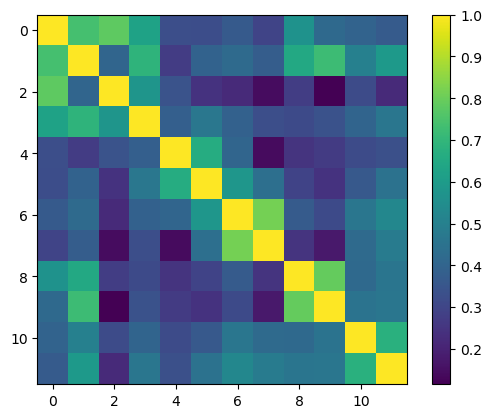

In [7]:
plt.imshow(np.corrcoef(time_series.transpose()))
plt.colorbar()

## Loading the data for the rest of the people

In [8]:
import glob
from nilearn import input_data, image

# Specify the base directory path where the files are located
base_directory = '/mnt/e/fmriprep/'

# Specify the pattern of the file names for the functional images
func_pattern = 'sub-*'

# Find all subdirectories that match the pattern
sub_dirs = glob.glob(base_directory + func_pattern)

# Extract the subject numbers from the subdirectory paths
subject_numbers = [sub_dir.split('-')[1] for sub_dir in sub_dirs]
# subject_numbers = subject_numbers[0:5]

# save to list
corr_mat = list()

# Loop over the subject numbers and process the files
for subject in subject_numbers:
    # Construct the file path using the subject number
    func_file = base_directory + f'sub-{subject}/func/sub-{subject}_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
    
    # Load the functional image
    func_img = image.load_img(func_file)
    
    # Process the image as needed
    import pandas as pd

    # Specify the path(s) of the confound file(s)
    confound_files = '/mnt/e/fmriprep/sub-002/func/sub-002_task-rest_desc-confounds_timeseries.tsv'

    # Specify the columns you want to select
    selected_columns = ['dvars', 'framewise_displacement', 'trans_x','trans_y','trans_z', 'rot_x', 'rot_y', 'rot_z']  # Replace with the names of the columns you want to select

    # Read the TSV file into a pandas DataFrame
    df = pd.read_csv(confound_files, delimiter='\t')

    # Select only the specified columns
    selected_df = df[selected_columns]
    selected_df.iloc[0]['dvars'] = 0
    selected_df.iloc[0]['framewise_displacement'] = 0
    
    time_series = aal_masker.fit_transform(func_img, confounds=selected_df)
    corr_mat.append(np.corrcoef(time_series.transpose()))

    # Save the correlation matrix to a file
    output_file = f'/mnt/e/fmriprep/subject-{subject}_correlation_matrix.npy'
    np.save(output_file, np.corrcoef(time_series))

    # Print the subject number and file path as an example
    print(f"Subject: {subject}, File: {func_file}")


Subject: 002, File: /mnt/e/fmriprep/sub-002/func/sub-002_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Subject: 004, File: /mnt/e/fmriprep/sub-004/func/sub-004_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Subject: 005, File: /mnt/e/fmriprep/sub-005/func/sub-005_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Subject: 006, File: /mnt/e/fmriprep/sub-006/func/sub-006_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Subject: 007, File: /mnt/e/fmriprep/sub-007/func/sub-007_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Subject: 008, File: /mnt/e/fmriprep/sub-008/func/sub-008_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Subject: 009, File: /mnt/e/fmriprep/sub-009/func/sub-009_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Subject: 010, File: /mnt/e/fmriprep/sub-010/func/sub-010_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Subject: 011, File: /mnt/e/fmriprep/sub-011/func/sub-011

## Create a matrix for each person

In [9]:
corr_mat_all = np.stack(corr_mat,axis = 2)
corr_mat_all.shape

(12, 12, 35)

calculate the correlation between ROIs (here we use Precentral_R & Insula_L as an example)

In [10]:
corr_mat_all[1, 2, :]

array([ 0.4026366 ,  0.49615109,  0.48023014,  0.71019184,  0.65703314,
        0.55781358,  0.4631966 ,  0.47577012,  0.61810937,  0.66268062,
        0.9318031 , -0.1120791 ,  0.81769259,  0.87788753,  0.43171089,
        0.68110947,  0.43745205,  0.59433795,  0.86709072,  0.57139603,
        0.21415195,  0.51767991,  0.43081098,  0.57565145,  0.50782895,
        0.52798492,  0.76023768,  0.71682543,  0.28123229,  0.49487248,
        0.54437222,  0.65583824,  0.40580425,  0.28303434,  0.5507372 ])

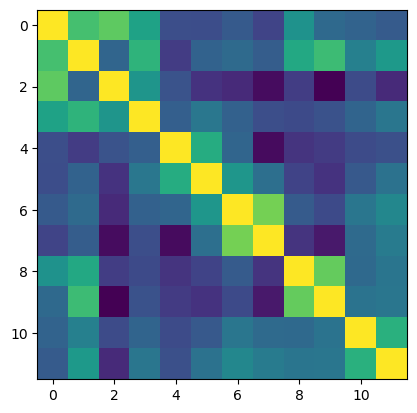

In [11]:
plt.imshow(corr_mat[0])

## Define the group of each subject.

In [12]:
import pandas as pd

# Specify the path(s) of the confound file(s)
group_files = '/mnt/e/fmriprep/Clinical_fm_66.csv'

# Specify the columns you want to select
selected_columns2 = ['rid', 'gp']  # Replace with the names of the columns you want to select

# Read the TSV file into a pandas DataFrame
df2 = pd.read_csv(group_files, delimiter=',')

# Select only the specified columns
selected_df2 = df2[selected_columns2]
# Now `selected_df` contains the DataFrame with only the selected columns
print(selected_df2.head())  # Print the first few rows of the selected DataFrame


   rid  gp
0    2   0
1    4   0
2    5   0
3    6   0
4    7   1


In [13]:
import numpy as np

# Convert 'gp' column values into group array
group = np.where(selected_df2['gp'] == 0, 'FM', 'HC')

# Print the group array
print(group)


['FM' 'FM' 'FM' 'FM' 'HC' 'FM' 'FM' 'FM' 'FM' 'HC' 'FM' 'HC' 'FM' 'HC'
 'FM' 'HC' 'FM' 'FM' 'HC' 'HC' 'FM' 'FM' 'FM' 'HC' 'FM' 'FM' 'HC' 'HC'
 'HC' 'HC' 'HC' 'HC' 'FM' 'FM' 'FM']


In [14]:
import numpy as np

# Convert 'gp' column values into group array
group = np.where(selected_df2['gp'] == 0, 0, 1)

print(group)

# # Create FM array from group array
# FM = np.array(group == 1)

# # Print the FM array
# print(FM)


[0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 0 0]


There are 21 patients (FM) and 14 healthy controls (HC).

In [15]:
corr_mat_FM = corr_mat_all[:, :, group == 0]
corr_mat_FM.shape


(12, 12, 21)

In [16]:
corr_mat_HC = corr_mat_all[:, :, group == 1]
corr_mat_HC.shape

(12, 12, 14)

In [17]:
from scipy.stats import ttest_ind

In [18]:
tstats, pval = ttest_ind(corr_mat_FM, corr_mat_HC, axis = 2)

/tmp/ipykernel_247/1939813480.py:1: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  tstats, pval = ttest_ind(corr_mat_FM, corr_mat_HC, axis = 2)


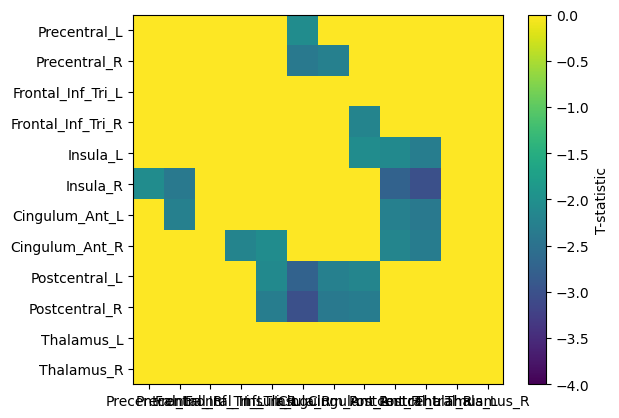

In [19]:
masked_tstats = tstats
masked_tstats[pval>0.05] = 0
plt.imshow(masked_tstats, vmin = -4) #use vmin to masked not values
plt.xticks(range(len(roi_names)), roi_names)
plt.yticks(range(len(roi_names)), roi_names)
# Add color bar
cbar = plt.colorbar()
cbar.set_label('T-statistic')
plt.show()